# Exploratory data analysis

##Kallisto
transcripts per million output was obtained from cluster

In [8]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [65]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [66]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [67]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

###Looking at a single file

In [10]:
Fr188_C1=pd.read_csv("/Users/leandraking/Desktop/SacktonProject/KallistoFiles/Fr188_C1_TTAGGC/abundance.tsv",sep="\t")


In [11]:
Fr188_C1.head()

,target_id,length,eff_length,est_counts,tpm
0,FBtr0071764,5173,4974,33.8472,0.504464
1,FBtr0100521,4665,4466,179.1580,2.973920
2,FBtr0071763,4847,4648,142.0220,2.265180
3,FBtr0342981,3897,3698,36.9729,0.741191
4,FBtr0083388,3935,3736,103.4280,2.052320


Checking that tpm sum up to 1000000

In [25]:
sum(Fr188_C1.tpm) , len(Fr188_C1)

(999999.92981562519, 30446)

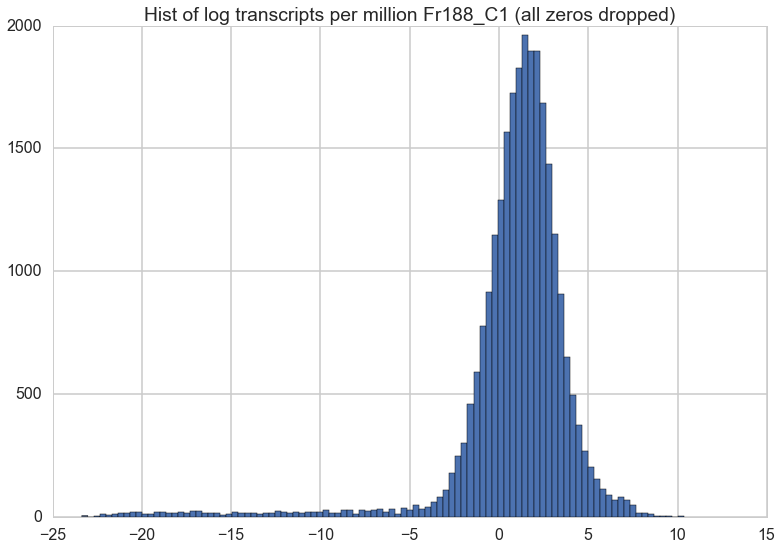

In [28]:
plt.hist(np.log(Fr188_C1[Fr188_C1.tpm>0].tpm), bins=100)
plt.title("Hist of log transcripts per million Fr188_C1 (all zeros dropped)")
plt.show()

###Looking at the output of all Fr files

In [93]:
#Create a dataframe with tpm data from all files
import glob
import string
files_dict={}
for fl in glob.glob("./KallistoFiles/*"):
    a= string.join(fl.split('/')[2].split('_')[:2], sep="_")
    if a:
        files_dict[a]=pd.read_csv(fl+"/abundance.tsv", sep="\t").tpm

df=pd.DataFrame(files_dict)

In [63]:
df.head()

,Fr188_C1,Fr188_C2,Fr188_C3,Fr188_T3,Fr188_T5,Fr188_T6,Fr89_C1,Fr89_C2,Fr89_C4,Fr89_T3,Fr89_T4,Fr89_T5
0,0.504464,1.284890,0.614044,0.00000,0.000000,0.000000,0.440369,0.691164,0.262204,0.000000,0.147861,0.00000
1,2.973920,4.151500,5.322480,3.70415,5.352650,3.635080,10.496100,8.771190,1.165150,4.027210,3.819260,5.20589
2,2.265180,1.434560,0.000000,0.00000,0.000000,0.461069,1.724620,0.563522,5.122970,0.000000,0.000000,0.00000
3,0.741191,0.350953,0.000484,0.00000,0.445147,0.000000,0.923483,0.000000,1.166280,0.158618,0.428323,0.00000
4,2.052320,0.690347,1.806490,3.43484,4.507330,4.265000,2.172480,0.869259,1.108070,3.678080,3.580640,3.87075


###Do a PCA

In [83]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X = pca.fit_transform(df.transpose())

In [84]:
print pca.explained_variance_ratio_.sum()

1.0


In [85]:
pca.explained_variance_ratio_*100

array([  8.72014067e+01,   1.02350068e+01,   1.25948217e+00,
         5.18700313e-01,   3.06651380e-01,   1.96562562e-01,
         1.01826493e-01,   8.15627742e-02,   4.48768320e-02,
         3.33743556e-02,   2.05496063e-02,   5.04811927e-28])

In [104]:
#Labeling with either a C or T
TorClabels=[a.split('_')[1][0] for a in df.columns]
lineLabels=[filter(str.isdigit,a.split('_')[0]) for a in df.columns]
df2 = pd.DataFrame({"TorC":TorClabels, "lines":lineLabels})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df2["pc%i" % (i+1)] = X[:,i]
df2.head()


,TorC,lines,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12
0,C,188,-79193.214693,-1869.039073,-20198.279205,-4840.038031,-1502.600734,-1314.666847,-5620.984049,-1962.825696,756.620789,-220.857138,-70.815825,1.951069e-10
1,C,188,-80787.556631,-3632.448600,-6525.944989,5666.852563,219.639371,948.966603,1601.991159,1519.193875,-3372.870582,426.330815,2644.981454,1.951069e-10
2,C,188,-78364.267835,845.358007,17108.301469,5460.000206,3062.235393,2966.580651,-4244.781432,-304.071936,-1952.804660,93.070667,-1637.316743,1.951069e-10
3,T,188,64447.225289,86787.400869,110.692736,212.107206,-2118.874915,1034.572296,-201.047499,824.567402,247.963358,-679.196498,194.208515,1.951069e-10
4,T,188,77914.303259,-18276.520058,2337.500160,3090.391919,-5488.546355,-7004.134496,846.154945,-1763.628345,-1842.991786,-2696.553199,-607.159028,1.951069e-10


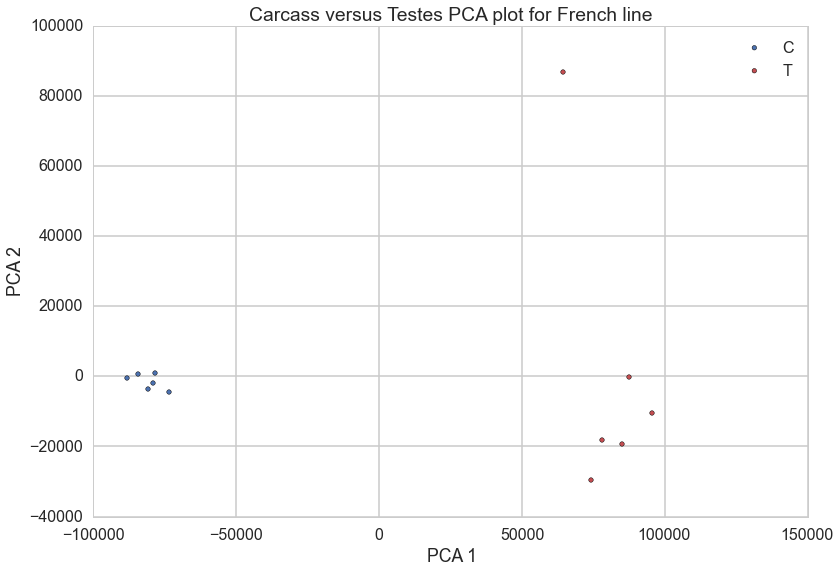

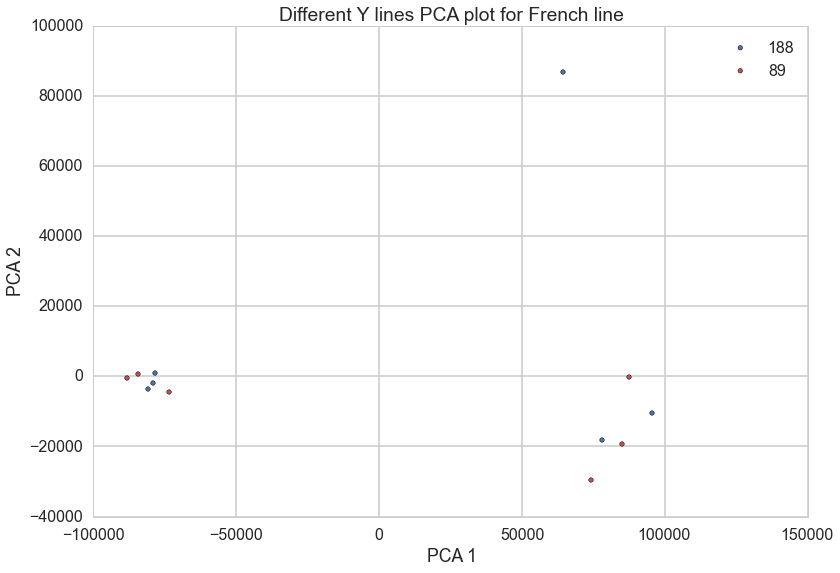

In [108]:
colors = [c0, c2]
for label, color in zip(df2['TorC'].unique(), colors):
    mask = df2['TorC']==label
    plt.scatter(df2[mask]['pc1'], df2[mask]['pc2'], c=color, label=label)
plt.legend()
plt.title("Carcass versus Testes PCA plot for French line")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

plt.figure()
for label, color in zip(df2['lines'].unique(), colors):
    mask = df2['lines']==label
    plt.scatter(df2[mask]['pc1'], df2[mask]['pc2'], c=color, label=label)
plt.legend()
plt.title("Different Y lines PCA plot for French line")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Good news!  Carcass points cluster together.  Lines do not cluster together